#### Christopher B. Johnson
#### 11/12/17


# Project: Investigate What Makes a Movie Exceptional

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#dfMoney">Creating Money Dataframe</a></li>
<li><a href="#dfQuality">Creating Quality Dataframe</a></li>
<li><a href="#dfPopularity">Creating Popularity Dataframe</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

>This project will explore the different variables involved in making movies that are exceptional.  So, what defines a good movie?  

>  First, we will assume that quality is the defining characteristic of a good movie.  Then, we'll look to see if there are correlations between quality and budget (if you spend enough money, will you create something good?).  Next we'll consider the quality of a movie as defined by popularity.  If enough people go to see the movie, must it be a quality film?  

>Finally, we'll take a different approach and assume that quality is not the only valid indicator of a good movie.  A good movie could be defined in three ways : popularity, film profit as proportion of budget (here I'm going to adjust this result by budget, so that a film with a 1 million dollar budget that makes 1 million in profits is considered more successful than a 100 million dollar budget film that makes 1 million)  $$filmProfit = \frac{revenue-budget}{budget}$$, or finally the average voter score.  These three dependent variables address the more generic variables of fame, fortune, and quality, respectively.  Finally, there is my opinion on the matter, which after a brief review of the data, suggests that this is a highly subjective topic.

>  Given the size of the dataset (approximately 10,000 movies), each definition of successful will be set to the top 500 movies (5%), since this appears to capture most of the significant information.

## Questions

>>1. Is there any correlation between the budget of successful movies and their perceived quality?
>>2. Is the popularity of a film an indicator of its quality?
>>3. Is there some common combination of genres that most successful movies share?

>>>Perhaps success is not so much dictated by budget and quality, but more simply because most people enjoy certain types of movies.  Analogously, just because you build the best product does not mean that it will enjoy success.  For instance, you might build the best grapefruit juicer in the world at the lowest cost, but if most people don't like grapefruit juice, your product will never be hugely successful.

### Data Uncertainty and why certain parameters were selected
> The current website for this data is at https://www.kaggle.com/tmdb/tmdb-movie-metadata

> While their website confirms that the existing zeros in the data are to be ignored, it does not answer how the budget_adj and revenue_adj columns are to be considered.  Since these numbers went down in some cases, I don't think that it's adjusting for 2017 dollars, but instead it may be the actual values after review?  Revenues also dropped after adjustment in some cases, and it's just not clear what these adjusted numbers represent, so they will not be used.

In [153]:
#import all packages for this analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#make all plots in the notebook vs separate window
%matplotlib inline


<a id='wrangling'></a>
### Data Wrangling Issues
> In this section, the movie csv file is loaded into a dataframe and the tail is displayed to show some concerns with the data.  The concerns are as follows :
1.  There are zeroes in the budget, revenue, budget_adj and revenue_adj columns.  These are likely not real values, and are simply placeholders.  These movies will not be included in the assessment of success using net profits, as they would wildly skew the results, and there is no immediate way to easily resolve the lack of information.
2.  There are some useless columns that are cluttering up the table for this analysis, such as homepage, tagline, and overview, and will not be used.  While it could be interesting to look at the vocabulary and punctuation to see if say, more !'s result in more viewers, this will not be pursued.
3.  While creating the money rank, the highest performers had a rank of over 1 million.  Upon further inspection, for those movies, someone had entered the budget assuming millions and then put down absolute revenue.  For example, id 10495, Karate Kid III has a budget of 113.00 and a revenue of 115103979.  While it's rather crude, I'm going to assume that all movies have a budget of greater than 100,000.  I'm going to leave the revenue alone for now.
4.  While working on casting the genres from lists to sets, it failed on index 426, which is a blank cell.  It was identifying this cell as float instead of empty list.  This was a lesson in groupby not taking mutable types, so I cast the column to string, then split on |, converted to set (to remove duplicates), and then sorted the set and cast to tuple (a non-mutable iterator which can be used by groupby).  This fixed the genre column, and while I also applied it to director (likely unnecessary) and actors (flawed due to it not finding individuals so much as a certain group...that works for genre, but not so much for actors).  This continuing increase in depth and complexity of analysis is why I stopped exploring at genres, since I'm not convinced there is an obvious stopping point.

### General Properties
>This section simply takes the tail of the data as a good example of some columns that have 0 for money (eliminate) and NaN for certain text columns, which also needs to be eliminated.  The intent here is to show a quick review of the data with some of its problems.

In [154]:
# Loading the movie data and doing an initial inspection.  Other problems were found as documented above.

filename = 'tmdb-movies.csv'
df_movies = pd.read_csv(filename)
print df_movies.tail()

          id    imdb_id  popularity  budget  revenue  \
10861     21  tt0060371    0.080598       0        0   
10862  20379  tt0060472    0.065543       0        0   
10863  39768  tt0060161    0.065141       0        0   
10864  21449  tt0061177    0.064317       0        0   
10865  22293  tt0060666    0.035919   19000        0   

                 original_title  \
10861        The Endless Summer   
10862                Grand Prix   
10863       Beregis Avtomobilya   
10864    What's Up, Tiger Lily?   
10865  Manos: The Hands of Fate   

                                                    cast homepage  \
10861  Michael Hynson|Robert August|Lord 'Tally Ho' B...      NaN   
10862  James Garner|Eva Marie Saint|Yves Montand|Tosh...      NaN   
10863  Innokentiy Smoktunovskiy|Oleg Efremov|Georgi Z...      NaN   
10864  Tatsuya Mihashi|Akiko Wakabayashi|Mie Hama|Joh...      NaN   
10865  Harold P. Warren|Tom Neyman|John Reynolds|Dian...      NaN   

                 director            

### Prepare the data for investigation

>The approach here will be to create multiple tables much like preparing a schema for a database.  Once the tables are built, we can sort them as desired, and then do the necessary joins to create the associations in preparation for display.

>First prepare the table of independent variables.  The common fields dataframe had problems; specifically, around index 426, there was an empty cell in the data which was considered a float, when all other values were objects.  This caused a crash.  The intent with the genres was to look at what combinations of genres would be associated with successful movies, so it was desireable to capture the combinations.  However, this resulted in combinations such as (drama,comedy) and (comedy,drama) showing up as separate entries.  The answer is to simply compare sets, but that became difficult since groupby will not work on mutable data objects.  So, while tuples would work, they didn't actually solve the problem of order significance.  Hence the solution below of first casting to string (eliminate the float) so I can split to a list on a | token.  Then take the list and convert to a set to eliminate any possible duplicates in the data set.  Finally return the sorted tuple, to fix the order significance problem when feeding into groupby.

In [155]:
independentFields = ['id','budget','cast','director','genres']
df_commonFields = pd.read_csv(filename,usecols=independentFields)

#define function to take in dataframe of independent fields and groom it to support groupby functions
listOfColumns = ['genres','cast','director']
#need to convert from set to tuple b/c groupby can't work on mutable objects
#https://stackoverflow.com/questions/39622884/pandas-groupby-over-list
def groomIndependentVars(df, colList):
    def setToTuple(x):
        return tuple(sorted(x))
    for column in colList:
        df[column] = df[column].astype(str)
        df[column] = df[column].str.split(pat='|')
        df[column] = df[column].apply(set)
        df[column] = df[column].apply(setToTuple)
    return df

df_commonFields = groomIndependentVars(df_commonFields,listOfColumns)

<a id='dfMoney'></a>
### Create movies ranked by money dataframe

Find the top 500 movies as defined by monetary success.  There were some problems when merging the money dataframe with the commonField dataframe above, as both had the budget column.  A fix for this was to create a suffix on the current table and then drop that column after the merge.

In [156]:
################by money :
moneyFields = ['id','budget','revenue']
df_movieMoney = pd.read_csv(filename, usecols=moneyFields)
#prep money fields to float for division
#https://stackoverflow.com/questions/15891038/change-data-type-of-columns-in-pandas
df_movieMoney[['budget','revenue']] = df_movieMoney[['budget','revenue']].astype(float)

def rankByMoney(df):
    if (df['revenue'] > 1) and (df['budget'] > 100000):
        return (df['revenue'] - df['budget']) / df['budget']
    else:
        return -100

#using sort_values due to this timing experiment :
#https://stackoverflow.com/questions/41825978/sorting-columns-and-selecting-top-n-rows-in-each-group-pandas-dataframe
df_movieMoney['moneyRank'] = df_movieMoney.apply(rankByMoney, axis=1).sort_values(ascending = False)

#now get top 500 moneyRanked movies and look for common directors
df_topMovieMoney = df_movieMoney.sort_values(by=['moneyRank'],ascending=False).head(500)

dfMergedMoney = df_topMovieMoney.merge(df_commonFields, on='id', how='inner', suffixes=('', '_'))
#now fix merge
#https://stackoverflow.com/questions/40343061/duplicate-columns-with-pandas-merge
dfMergedMoney.drop('budget_', axis=1, inplace=True)

#look at most popular genres for top money makers
topMoneyGenres = dfMergedMoney.groupby(dfMergedMoney['genres']).size().sort_values(ascending=False).head(25)
#look at most popular directors for top money makers
#print dfMergedMoney.groupby(dfMergedMoney['director']).size().sort_values(ascending=False).head()
#now look at actors in top money making movies
#print dfMergedMoney.groupby(dfMergedMoney['cast']).size().sort_values(ascending=False).head()

While I did not do this initially, a histogram of the money statistic would have proved helpful to determine how to examine the data.  After working with all of the data for a while, it became evident that there were many situations where the data was highly skewed to a particular value (for instance, there are a number of movies with only a few reviewers).  So, to start the data preparation, let's look at how the data is distributed to estimate how many data samples of the population would be meaningful.

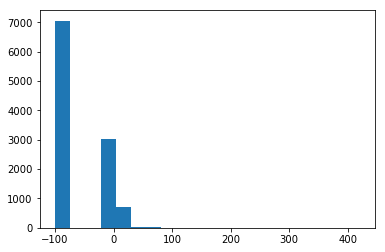

In [157]:
plt.hist(df_movieMoney['moneyRank'],bins = 20);

As can be seen in the histogram above, it seems to have been a good decision to select only the top 500 movies for analysis, as many more actually lost money, and almost 7000 of the 10000 movies available either had incomplete data, or budgets under 100,000 dollars. The budget limit may have been in error, but let's look at the budget histogram.

Number of movies with budgets under 100,000 but above 0, with revenues greater than 0 :  40
         id   budget    revenue  moneyRank
1354    985  10000.0  7000000.0     -100.0
1733  22717     75.0      134.0     -100.0
1871  42151  31192.0    10000.0     -100.0
2207  42296  30000.0  3045943.0     -100.0
2227  38568  30000.0   617000.0     -100.0


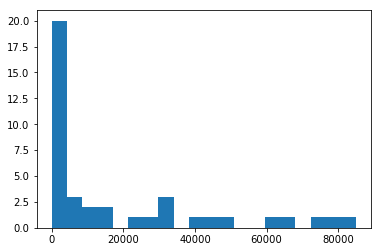

In [158]:
df_movieMoney100Hist = df_movieMoney[(df_movieMoney['budget']<100000) & (df_movieMoney['budget']>1) & \
                                    (df_movieMoney['revenue'] > 0)]
print "Number of movies with budgets under 100,000 but above 0, with revenues greater than 0 : ",len(df_movieMoney100Hist)
print df_movieMoney100Hist.head()
plt.hist(df_movieMoney100Hist['budget'], bins=20);

As the idea of using histograms to better select my data arrived after I put most of this together, I'm going to leave this mistake in this report.  The histogram above shows that I left out 40 movies that had legitimate budget/revenue streams, but I did not think to include them originally due to a more 'by brief inspection of the spreadsheet' approach.

However, this does mean that the results of the money ranking will be significantly skewed, as these movies could possibly be some of the highest earners, as defined above.  I find my mistake here interesting, which is why I've left it in.

<a id='dfQuality'></a>
### Create movies ranked by quality dataframe

Now find the top 500 movies ranked by quality.  This required a bit of consideration as to what the balance should be between the actual vote average versus the number of votes.  The fewer votes there were for a movie greatly increased the volatility of its rank.  In looking at the statstical description of the voter fields, the mean was low and the standard deviation quite high, relatively speaking.  So instead, looking at the IQR for the data seemed to indicate that there were a lot of movies with very few votes, so I decided that if I simply eliminated the bottom 50 percent of movies due to insufficient votes (making the score unreliable), I might capture a reasonable indicator of quality.  So, 38 votes was that cutoff at 50%.

Also, I did notice that the top ranked casting for these pictures is 'nan', but I decided to stop the exploration at the initial 3 questions due to the realization that there's always going to be 'one more thing' that can be considered.  Hence, there was no driving reason to clean the cast data.

In [159]:
###############by quality
qualityFields = ['id', 'vote_average', 'vote_count']
df_quality = pd.read_csv(filename, usecols=qualityFields)
#cast to float for possible division
df_quality[['vote_average', 'vote_count']] = df_quality[['vote_average', 'vote_count']].astype(float)

print df_quality[['vote_average', 'vote_count']].describe()

#since the standard deviation is greater than the mean, it is difficult to find meaning for review quality with few reviewers.  This makes sense, as the age of some of these movies would mean that they have less reviews.
#I'm going to ignore the number of reviews for this investigation
#standardize the average vote quality\
#The IQR at 50% is 38 votes, so let's make that the lower limit for ranking...it's not fair, but it should help eliminate artifically high scores due to few votes
#due to warnings...
#http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
df_quality.loc[:, 'voteValStandardized']=((df_quality.loc[:, 'vote_average'] - df_quality.loc[:, 'vote_average'].mean()) / df_quality.loc[:, 'vote_average'].std(ddof=0))

print df_quality.sort_values('voteValStandardized', ascending=False).head()
df_qualityReviewNumbers = df_quality[df_quality['vote_count'] >= 38]
df_qualityReviewNumbers = df_qualityReviewNumbers.sort_values('voteValStandardized', ascending=False).head(500)
print df_qualityReviewNumbers.sort_values('voteValStandardized', ascending=False).head()

#now analyze quality
dfMergedQuality = df_qualityReviewNumbers.merge(df_commonFields, on='id', how='inner')
topQualityGenres = dfMergedQuality.groupby(dfMergedQuality['genres']).size().sort_values(ascending=False).head(25)
#look at most popular directors for top quality
print dfMergedQuality.groupby(dfMergedQuality['director']).size().sort_values(ascending=False).head()
#now look at actors in top quality movies
print dfMergedQuality.groupby(dfMergedQuality['cast']).size().sort_values(ascending=False).head()

       vote_average    vote_count
count  10866.000000  10866.000000
mean       5.974922    217.389748
std        0.935142    575.619058
min        1.500000     10.000000
25%        5.400000     17.000000
50%        6.000000     38.000000
75%        6.600000    145.750000
max        9.200000   9767.000000
          id  vote_count  vote_average  voteValStandardized
3894  125336        14.0           9.2             3.448917
538   224972        11.0           8.9             3.128095
2269   51299        27.0           8.8             3.021155
1200  374430        41.0           8.8             3.021155
6911   24970        23.0           8.7             2.914214
          id  vote_count  vote_average  voteValStandardized
1200  374430        41.0           8.8             3.021155
3690   68450        60.0           8.5             2.700333
609   321640        72.0           8.4             2.593393
2397  241829        42.0           8.4             2.593393
4178     278      5754.0          

Again, let's look at the histogram of quality movies and evaluate whether the split at 38 was reasonable.

5397
5.76540670743


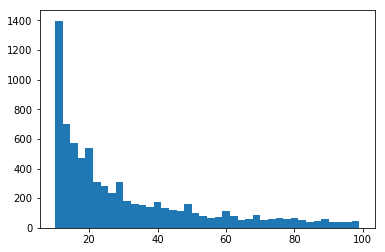

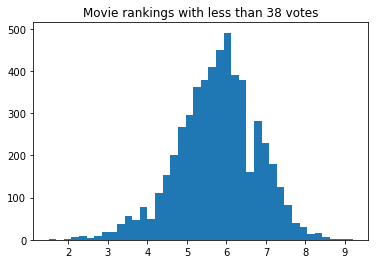

In [160]:
plt.hist(df_quality[df_quality['vote_count']<100]['vote_count'],bins=40);
#how many movies had fewer than 38 votes?
print len(df_quality[df_quality['vote_count']<38])
#make new plot
pltAvg = plt.figure()
#of those with fewer than 38 votes, where did the average movie rank fall?
plt.hist(df_quality[df_quality['vote_count']<38]['vote_average'],bins=40);
plt.title('Movie rankings with less than 38 votes');
print df_quality[df_quality['vote_count']<38]['vote_average'].mean()

From the above (top) histogram and the length of that dataset, it's obvious from the IQR in the description above that half of the movies have fewer than 38 votes (the exact point of the 50% IQR)).  So, given that there are ~5000 movies that had less than 38 votes, let's consider what that would have done to the movie rankings.  Looking at the lower histogram above, it's a rather normal distribution with a mean of 5.76.  While the majority of these rankings may not have influenced the ranking, I believe that the rankings of 8 and greater (maybe 50 movies) would have greatly affected the higher level rankings with very few votes, so it was a reasonable approach to eliminate all of these movies from the quality ranking. 

<a id='dfPopularity'></a>
### Create movies ranked by popularity dataframe

Finally, sort the data by movie popularity.

In [161]:
#################by popularity
popularFields = ['id','popularity']
dfPopularity = pd.read_csv(filename, usecols=popularFields)
#standardize popularity and rank
dfPopularity.loc[:,'popularityStandardized'] = (dfPopularity.loc[:,'popularity'] - dfPopularity.loc[:,'popularity'].mean())/dfPopularity.loc[:,'popularity'].std(ddof=0)
print dfPopularity.sort_values('popularityStandardized',ascending=False).head()
dfPopularityTop = dfPopularity.sort_values('popularityStandardized',ascending=False).head(500)
dfMergedPopularity = dfPopularityTop.merge(df_commonFields, on='id', how='inner')

topPopularGenres = dfMergedPopularity.groupby(dfMergedPopularity['genres']).size().sort_values(ascending=False).head(25)
#look at most popular directors for top quality
topPopularDirectors = dfMergedPopularity.groupby(dfMergedPopularity['director']).size().sort_values(ascending=False).head(10)
#now look at actors in top quality movies
topPopularCast = dfMergedPopularity.groupby(dfMergedPopularity['cast']).size().sort_values(ascending=False).head(10)


         id  popularity  popularityStandardized
0    135397   32.985763               32.334830
1     76341   28.419936               27.769638
629  157336   24.949134               24.299318
630  118340   14.311205               13.662866
2    262500   13.112507               12.464335


Again, let's look at the histogram for popularity.

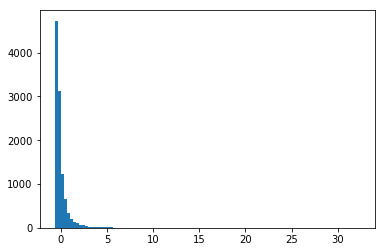

In [162]:
plt.hist(dfPopularity['popularityStandardized'],bins=100);

There are many movies that are not popular.  This would be a more challenging paper if the question were to find the worst movies of all time.  But since there are less data points for more popular movies, this seems to be a good measure to quantify the best of the best.

<a id='eda'></a>
## Exploratory Data Analysis

> To explore the data, first we'll take a look at some basic questions in an attempt to identify any simple correlations in the dataset.  Finally, we'll dive deeper into the data by looking at the three definitions of a 'successful' movie and attempt to identify any correlations between movie genres and successful movies.  

### Is there any correlation between the budget of successful movies and their perceived quality?
>Here we look at the standardized quality score versus a movie's budget.  There does appear to be a correlation that the more that is spent on a movie, the higher its standardized quality.

5000
Pearson's R of Quality vs. Money :  [-0.03545439]


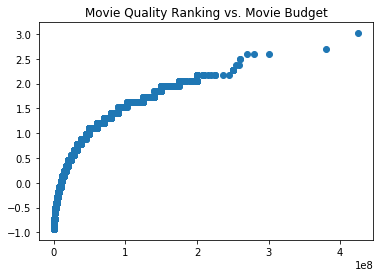

In [163]:
#CREATE SCATTERPLOT OF QUALITY VS MONEY -> RUN PEARSON'S R
df_topMoneyScatter = df_movieMoney[df_movieMoney['budget']>0].sort_values(by=['budget'],ascending=False).head(5000)
df_qualityReviewScatter = df_quality[df_quality['vote_count'] >= 38].sort_values('voteValStandardized', ascending=False).head(len(df_topMoneyScatter))
#put money on the x axis, and quality on y
N = len(df_topMoneyScatter)
print(N)
x = df_topMoneyScatter['budget']
y = df_qualityReviewScatter['voteValStandardized']

#https://pandas.pydata.org/pandas-docs/stable/merging.html
dfPearsonQuality = pd.concat([x,y],axis=1)
#https://stackoverflow.com/questions/34896455/how-to-do-pearson-correlation-of-selected-columns-of-a-pandas-data-frame
pearsonRMoney = dfPearsonQuality[dfPearsonQuality.columns[0:]].corr(method='pearson')['voteValStandardized'][:-1]
print "Pearson's R of Quality vs. Money : ",pearsonRMoney.values

plt.scatter(x,y)
plt.title('Movie Quality Ranking vs. Movie Budget')
plt.show()

The scatterplot above seems to indicate that there is an exponential relationship between movies as ranked by money vs. quality.  However, Pearson's R only works on linear relationships, so there is very little correlation according to that method.  I am as of yet, unfamiliar with the appropriate method with which to evaluate an exponential relationship.

The normalized quality on the y-axis should be read that at 0, the quality of the movie was 50/50. Once the studio allocates a budget of 100 million or greater for the movie, the standardized quality is 1.5 standard deviations above the mean, or about 50+34+6.75 = 90.75% of the rankings fell below that point.  In other words, after the studio budgets 100 million for a movie, the movie seems to always rank in the top 9.25% of all rankings, relatively speaking.  This does not mean that it received a review of 90% or higher.  It just means that big budget movies tend to sit in the top 10% of all rankings.  If the top ranked movie was 'Meh, ok', then big budget movies would be in the top 10% of 'Meh, ok' movies. 

### Is the popularity of a film an indicator of its quality?
> Here we again look at standardized quality versus its popularity. I am somewhat unclear from the dataset exactly what a popularity of 10 or 20 actually means, but I can say that higher is more popular, and we can derive meaning from that.

5469
Pearson's R of Quality vs. Popularity :  [ 0.26730552]


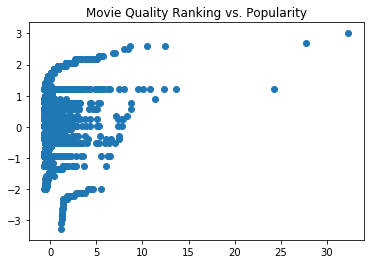

In [164]:
#CREATE SCATTERPLOT OF POPULARITY VS QUALITY -> RUN PEARSON'S R
df_qualityReviewScatter = df_quality[df_quality['vote_count'] >= 38].sort_values('voteValStandardized', ascending=False)
N=len(df_qualityReviewScatter)
print(N)

x = dfPopularity['popularityStandardized'].head(len(df_qualityReviewScatter))
y = df_qualityReviewScatter['voteValStandardized']

dfPearsonPopular = pd.concat([x,y],axis=1)
pearsonRqvsp = dfPearsonPopular[dfPearsonPopular.columns[0:]].corr(method='pearson')['voteValStandardized'][:-1]
print "Pearson's R of Quality vs. Popularity : ",pearsonRqvsp.values
plt.scatter(x,y)
plt.title('Movie Quality Ranking vs. Popularity')
plt.show()

This scatterplot of Quality vs. Popularity is somewhat surprising in that until the popularity is a 10 or above, there is seemingly no significant correlation between popularity and quality.  Let's look at a histogram of standardized quality where popularity is less than 10.

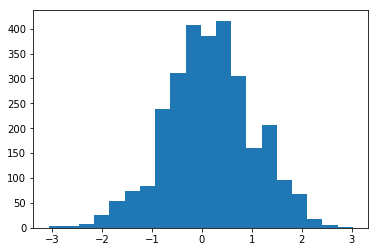

In [165]:
histQuality= dfPearsonPopular[dfPearsonPopular['popularityStandardized']<10]['voteValStandardized']
plt.hist(histQuality.dropna(),bins = 20);

Interestingly enough, when the popularity of a movie is less than 10, the quality of the movie is a normal distribution around 0.  This shows that most movies are of average standardized quality.  Looking at a histogram of the popularity of the same group of films indicates that most films are not that popular, so the quality ranking of the least popular films is not very accurate (falls within 1 standard deviation of the mean quality ranking).

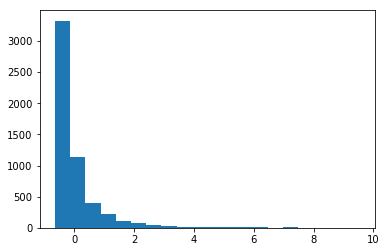

In [166]:
histPopularity = dfPearsonPopular[dfPearsonPopular['popularityStandardized']<10]['popularityStandardized']
plt.hist(histPopularity.dropna(), bins = 20);

### Is there some common combination of genres that most successful movies share?

>Taking all three of the definitions for movie success : Fame, Fortune and Quality, we now consider each of those dependent variables and look for correlations between the various genres and genre combinations.  Of the top ranked movies, the sample size was increased until approximately 10 genres were identified that were common to all 3 definitions of a successful movie.  The data printed out below gives exact numbers, and the bar chart below shows a more intuitive visualization of the results.

Index([(u'Action', u'Adventure', u'Science Fiction'),
                                        (u'Comedy',),
                                         (u'Drama',),
                  (u'Action', u'Crime', u'Thriller'),
                   (u'Comedy', u'Drama', u'Romance'),
                              (u'Drama', u'Romance'),
                                (u'Crime', u'Drama'),
                             (u'Crime', u'Thriller'),
                               (u'Comedy', u'Drama')],
      dtype='object', name=u'genres')
                                      genres_popular  genres_quality  \
genres                                                                 
(Action, Adventure, Science Fiction)              27              11   
(Comedy,)                                         19               8   
(Drama,)                                          18              64   
(Action, Crime, Thriller)                         11               4   
(Comedy, Drama, Romance)                   

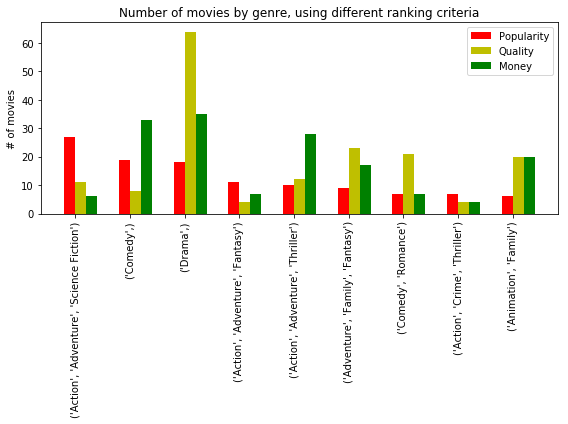

In [167]:
#PREPARE DATA FOR GRAPHING

#find common genres across 3 measures of movies
popularGenreList = list(topPopularGenres.index)
intersectTemp = topPopularGenres.index.intersection(topMoneyGenres.index)
intersectGenres = intersectTemp.intersection(topQualityGenres.index)
print intersectGenres
#NOW MERGE ALL VALUES FOR THESE CATEGORIES
#create dataframes from all previous assemblies to do merge on indices

df_PopularGenres = pd.DataFrame(topPopularGenres,columns=['genres'])
df_QualityGenres = pd.DataFrame(topQualityGenres,columns=['genres'])
df_MoneyGenres = pd.DataFrame(topMoneyGenres,columns=['genres'])
# genreComparison = df_PopularGenres.merge(df_QualityGenres,on='genres',how='inner')

#doing this eliminates the need to add the ,rsuffix='_1etc' in the join below
df_PopularGenres = df_PopularGenres.add_suffix('_popular')
df_QualityGenres = df_QualityGenres.add_suffix('_quality')
df_MoneyGenres = df_MoneyGenres.add_suffix('_money')
#THIS GUY!
#https://stackoverflow.com/questions/26366021/pandas-aligning-multiple-dataframes-with-timestamp-index
df_GenreResults = df_PopularGenres.join(df_QualityGenres,how='inner').join(df_MoneyGenres,how='inner')
print df_GenreResults


#CREATE BARCHART OF GENRES FROM ALL 3 CATEGORIES
#https://matplotlib.org/examples/api/barchart_demo.html
N=len(df_GenreResults) #the number of genre categories displayed
ind = np.arange(N) #x locations for the groups
width = 0.2

fig,ax = plt.subplots()
#rects1 = ax.bar(ind, dfMergedMoney.groupby(dfMergedMoney['genres']).size().sort_values(ascending=False).head(10),width,color='r')
rects1 = ax.bar(ind, df_GenreResults['genres_popular'], width, color='r')
rects2 = ax.bar(ind+width, df_GenreResults['genres_quality'], width, color='y')
rects3 = ax.bar(ind+2*width,df_GenreResults['genres_money'], width, color = 'g')

ax.set_ylabel('# of movies')
ax.set_title('Number of movies by genre, using different ranking criteria')
ax.set_xticks(ind+width/2)
ax.set_xticklabels(popularGenreList)
#https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib
plt.xticks(rotation=90)
#https://stackoverflow.com/questions/6774086/why-is-my-xlabel-cut-off-in-my-matplotlib-plot
fig.set_size_inches(8,6)
plt.tight_layout()
#subplots_adjust(top = 0.8, bottom=0.7)
ax.legend((rects1[0], rects2[0],rects3[0]),('Popularity','Quality','Money'))

plt.show()

The above bar chart is interesting if you consider the top three genres for all three definitions of successful movies.  

The top 3 genres in Popularity are :<br>
1) Action/Adventure/Science Fiction<br>
2) Comedy<br>
3) Drama<br>

The top 3 genres in Quality are :<br>
1) Drama<br>
2) Adventure/Family/Fantasy<br>
3) Comedy/Romance<br>

The top 3 genres in Money are :<br>
1) Drama<br>
2) Comedy<br>
3) Action/Adventure/Thriller<br>

The genres common to all are Drama, Comedy, and Adventure, in that order of significance.  It is probably not a coincidence that the top genres in money and popularity are almost identical, as the more popular a movie, the more ticket revenues that are collected, and hence more money made.

<a id='conclusions'></a>
## Conclusions

To review, we have investigated the general question of : 'What are the characteristics of a successful movie?'  The exploration began by assuming that good movies were of high quality. When looking at the studio budgets for the highest quality movies, there is a correlation between how much the studio spends and the standardized quality of a movie.  I cannot say that a higher budget creates higher rankings, as this would imply that at some point, a sufficiently large budget would guarantee a perfect ranking score.  However, it does appear that the higher budget films (budget > 100 million dollars) consistently score in the top 10% of all rankings

Next, continuing to assume that high quality movies are considered successful, a standardized quality score was compared to the popularity of the movie.  Perhaps the popular vote always chooses the highest quality film.  This was not a very good hypothesis.  There seemed to be some correlation betwen extremely popular films and quality.  While the popularity score went from 0-30, there were very few films with popularity scores above 10.  And yet, those films with popularity scores greater than 10 scored quite well in terms of standardized quality (standard deviation of > 1).  This means that generally, if 84% of people consider something popular, there is a correlation between that and high standardized quality (again, standard deviation of > 1, or a film that is in the top 16% of rankings).  Where this was more interesting is that once the popularity score dropped below 10 (where most films were), a histogram of the data indicated a normal distribution of quality scores almost centered on a standard deviation of 0.  Looking at a histogram of the popularity scores indicates that most films are not popular.  Combining those two statements and the histograms implies that low popularity movies tend to have average ratings within 1 standard deviation from the mean ratings.  In other words, there seems to be a correlation where the quality of a movie can be within +/- 34% of the average movie quality, and the general movie going masses (68%) will likely give it a try.  There is no causation here.

However, I think the truth of 'success' is different for different people.  So, expanding that definition of success to Popularity/Quality/Money, we looked at those different definitons of success in terms of movie genres.  Perhaps people like what they like, and for some, there is no such thing as a bad donut or pizza.  Now comparing these flavors of success versus the genre categories, there are some interesting results.

Looking at the top ranked genre for every category of success, why is each genre different?  For popularity, the top genre is Action/Adventure/Science Fiction.  Not only is this the most popular, it also happens to be very low on quality and money ranking.  I would imagine that this is the LotR/Star Wars crowd.  The films are very high budget, resulting in a relatively low budget/revenue score.  This crowd may see the same film multiple times, explaining a high popularity.  And if I were to use Clerks as a movie to explain the relationship between LotR and Star Wars types, I'd say that each ranks the other quite poorly, perhaps explaining a low quality score.  In addition, high budget movies, like realistic video games, may be stuck in the Uncanny Valley where when you try to make unreal things look real, it actually invokes a negative response in people.

Next, when considering Quality as the top definition for movie success, it seems that movies in the Drama genre are preferred.  Since i am not a big fan of drama, I find it difficult to explain why this is the case, but it is interesting in that it is also the highest rank in the Money category as well.  I would guess that these are the 'slice of life' movies like Apollo 11 where people overcomes great odds with a feel-good ending.  They likely do not have as many special effects as other genres, hence the good return on money, and consequently top the Quality/Money category.

A notable second place is the Comedy genre, which came in second for both Money and Popularity.  It would make sense that people like to laugh, but the low Quality score at first seems surprising.  However, when you consider the range of comedy, from chuckles in polite company, to the slapstick of Naked Gun, to South Park, the Venn diagram for comedy would have a very small intersection.

What are the characteristics of a good movie?  This exploration would have to conclude : It depends. I make no claims to any causal relationships, but if I were a movie studio after money, I might focus on Drama/Comedy genres.  If I were a movie goer, I would consider a few reviews unreliable, or perhaps look at the budget and consider that it will be at least a decent movie.  But ultimately, if you know what you like, you'll know the limits of what you're willing to explore, and like all exploration, there's always good with the bad.